In [1]:
## Pipeline encoding model
from encoding_tools import * ## make speciifci

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

import pickle
import os


In [2]:
# Load data from a given subject
task = 'VTCLoc'
subject_number = '132'
data_dir = '/Volumes/LBCN8T_2/Stanford/data/encoding/raw/' + task + '/'
data_dir = os.path.join('/Volumes/LBCN8T_2/Stanford/data/encoding/raw/', task)  #RP use os.path.join
X = load_stim_features(data_dir, subject_number)
y = load_brain_features(data_dir, subject_number)

FileNotFoundError: [Errno 2] File /Volumes/LBCN8T_2/Stanford/data/encoding/raw/VTCLoc132_stim_features.csv does not exist: '/Volumes/LBCN8T_2/Stanford/data/encoding/raw/VTCLoc132_stim_features.csv'

In [37]:
print('This subject has ', y.shape[1], ' implanted electrodes')
print('This subject has %s implanted electrodes' % y.shape[1])

print(f'This subject has {y.shape[1]} implanted electrodes')  # RP use this

This subject has 137 implanted electrodes


(-0.5, 2546.5, 1622.5, -0.5)

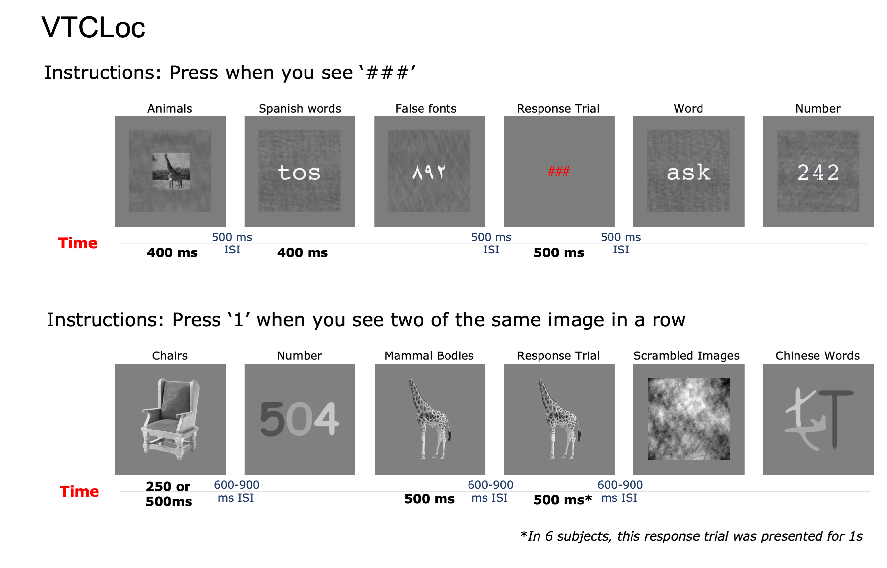

In [3]:
# Display task design
fig, ax = plt.subplots(figsize=(15,15))
img = plt.imread('/Volumes/LBCN8T_2/Stanford/data/encoding/tasks/' + task + '.png')
ax.imshow(img)
ax.axis('off')  #RP - one command per line

In [6]:
# Explore some features
X.head()

,task,trial,time,block,task_general_cond_name,task_type,StimulusOnsetTime,allonsets,RT_lock,bodies,buildings_scenes,faces,falsefonts,logos,numbers,objects,scrambled_images,shapes,words
0,1,1,0.000,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
1,1,1,0.002,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
2,1,1,0.004,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
3,1,1,0.006,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
4,1,1,0.008,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0


Text(0.5,0,'Electrode number')

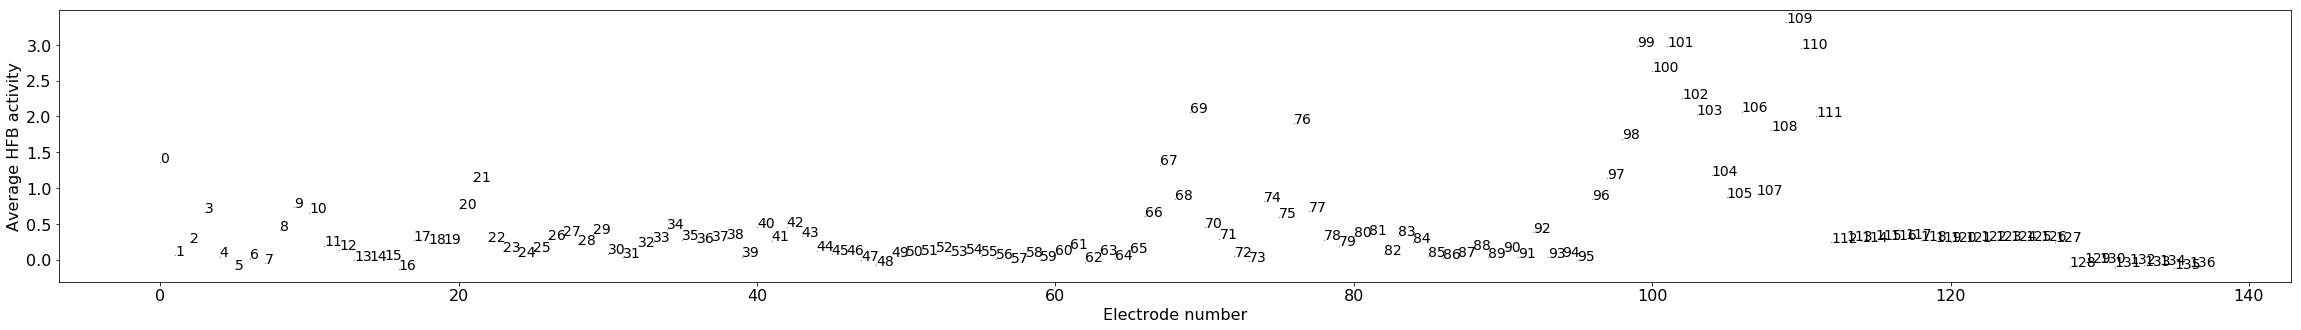

In [7]:
# Plot average activation per electrode
electrodes = np.arange(0, y.shape[1])
avg_activity = np.average(y, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(40, 5))
plt.scatter(electrodes,avg_activity, s=0.1)
for i, txt in enumerate(electrodes):
    ax.annotate(txt, (electrodes[i], avg_activity[i]), size=14)
plt.tick_params(labelsize=16);
ax.set_ylabel('Average HFB activity', size=16)
ax.set_xlabel('Electrode number', size=16)

In [73]:
# Get trials and times from X features
trials, times = define_trials(X)
# Get feature list from the task 
features_list = get_stim_features(data_dir, task, subject_number)
print('This subject has completed ' + str(trials) + ' trials of ' + task)
print('Each trial has ' + str(times) + ' time samples')
print('Relevant stimuli features:')
print(features_list)

NameError: name 'get_stim_features' is not defined

In [56]:
# Define delayed features
# times:
delay_params = get_delay_params(task)
X_delay, delays = delay_features(features_list, X,  delay_params)
print('Here we are creating ' + str(len(delays)) + ' delayed versions of each feature, every ' + str(step*1000) + ' ms')

Here we are creating 44 delayed versions of each feature, every 20.0 ms


In [14]:
# Fit non cross validate model on a given electrode
elect = 77
model_single = Ridge(alpha=1e5)
model_single.fit(scale(X_delay), scale(y[:,elect]))

Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

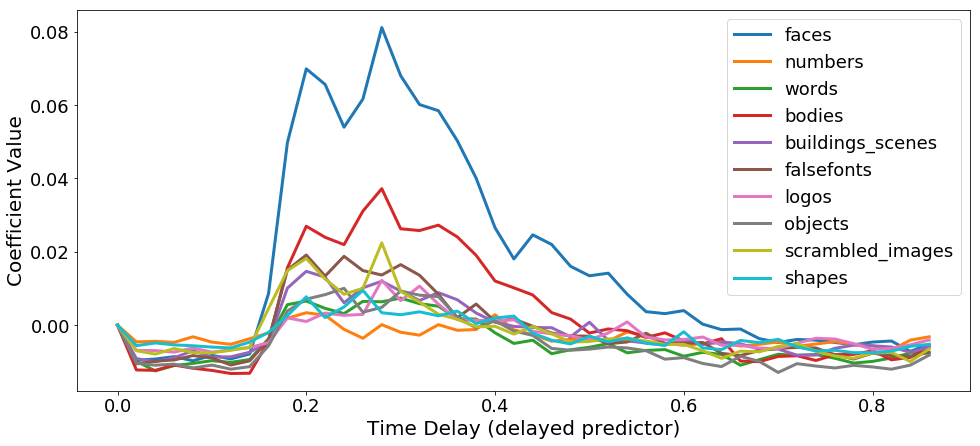

In [57]:
# Plot coefficients
coefs_rs = np.reshape(model_single.coef_, (len(features_list), len(delays)))
# Plot results
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(np.abs(delays), coefs_rs.T,  linewidth=3)

ax.set_xlabel('Time Delay (delayed predictor)', size=20)
ax.set_ylabel('Coefficient Value', size=20)
_ = ax.legend(features_list, fontsize=18)
plt.tick_params(labelsize=18);

In [11]:
# Fit cross validate model
cross_val_iterator = cross_validator(trials, 5)
model = Ridge(alpha=1e5)
model, scores_all, coefs_all, intercept_all = fit_encoding_model(model, cross_val_iterator, y, X, X_delay)

In [68]:
filename = data_dir + 'finalized_model.sav'
# use with instead of directly opening
with open(filename, 'wb') as f:
    pickle.dump(model, f)

In [69]:
loaded_model = pickle.load(open(filename, 'rb'))

Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [12]:
# Get the scores for single trials across all electrodes
score_metric = 'corr' # Pearson's r, r2_score from scikit learn can also be used
score_single_trials = single_trials_prediciton(model, y, X, X_delay, trials, 'corr') 
trial_idx = np.arange(0, trials)+1

faces


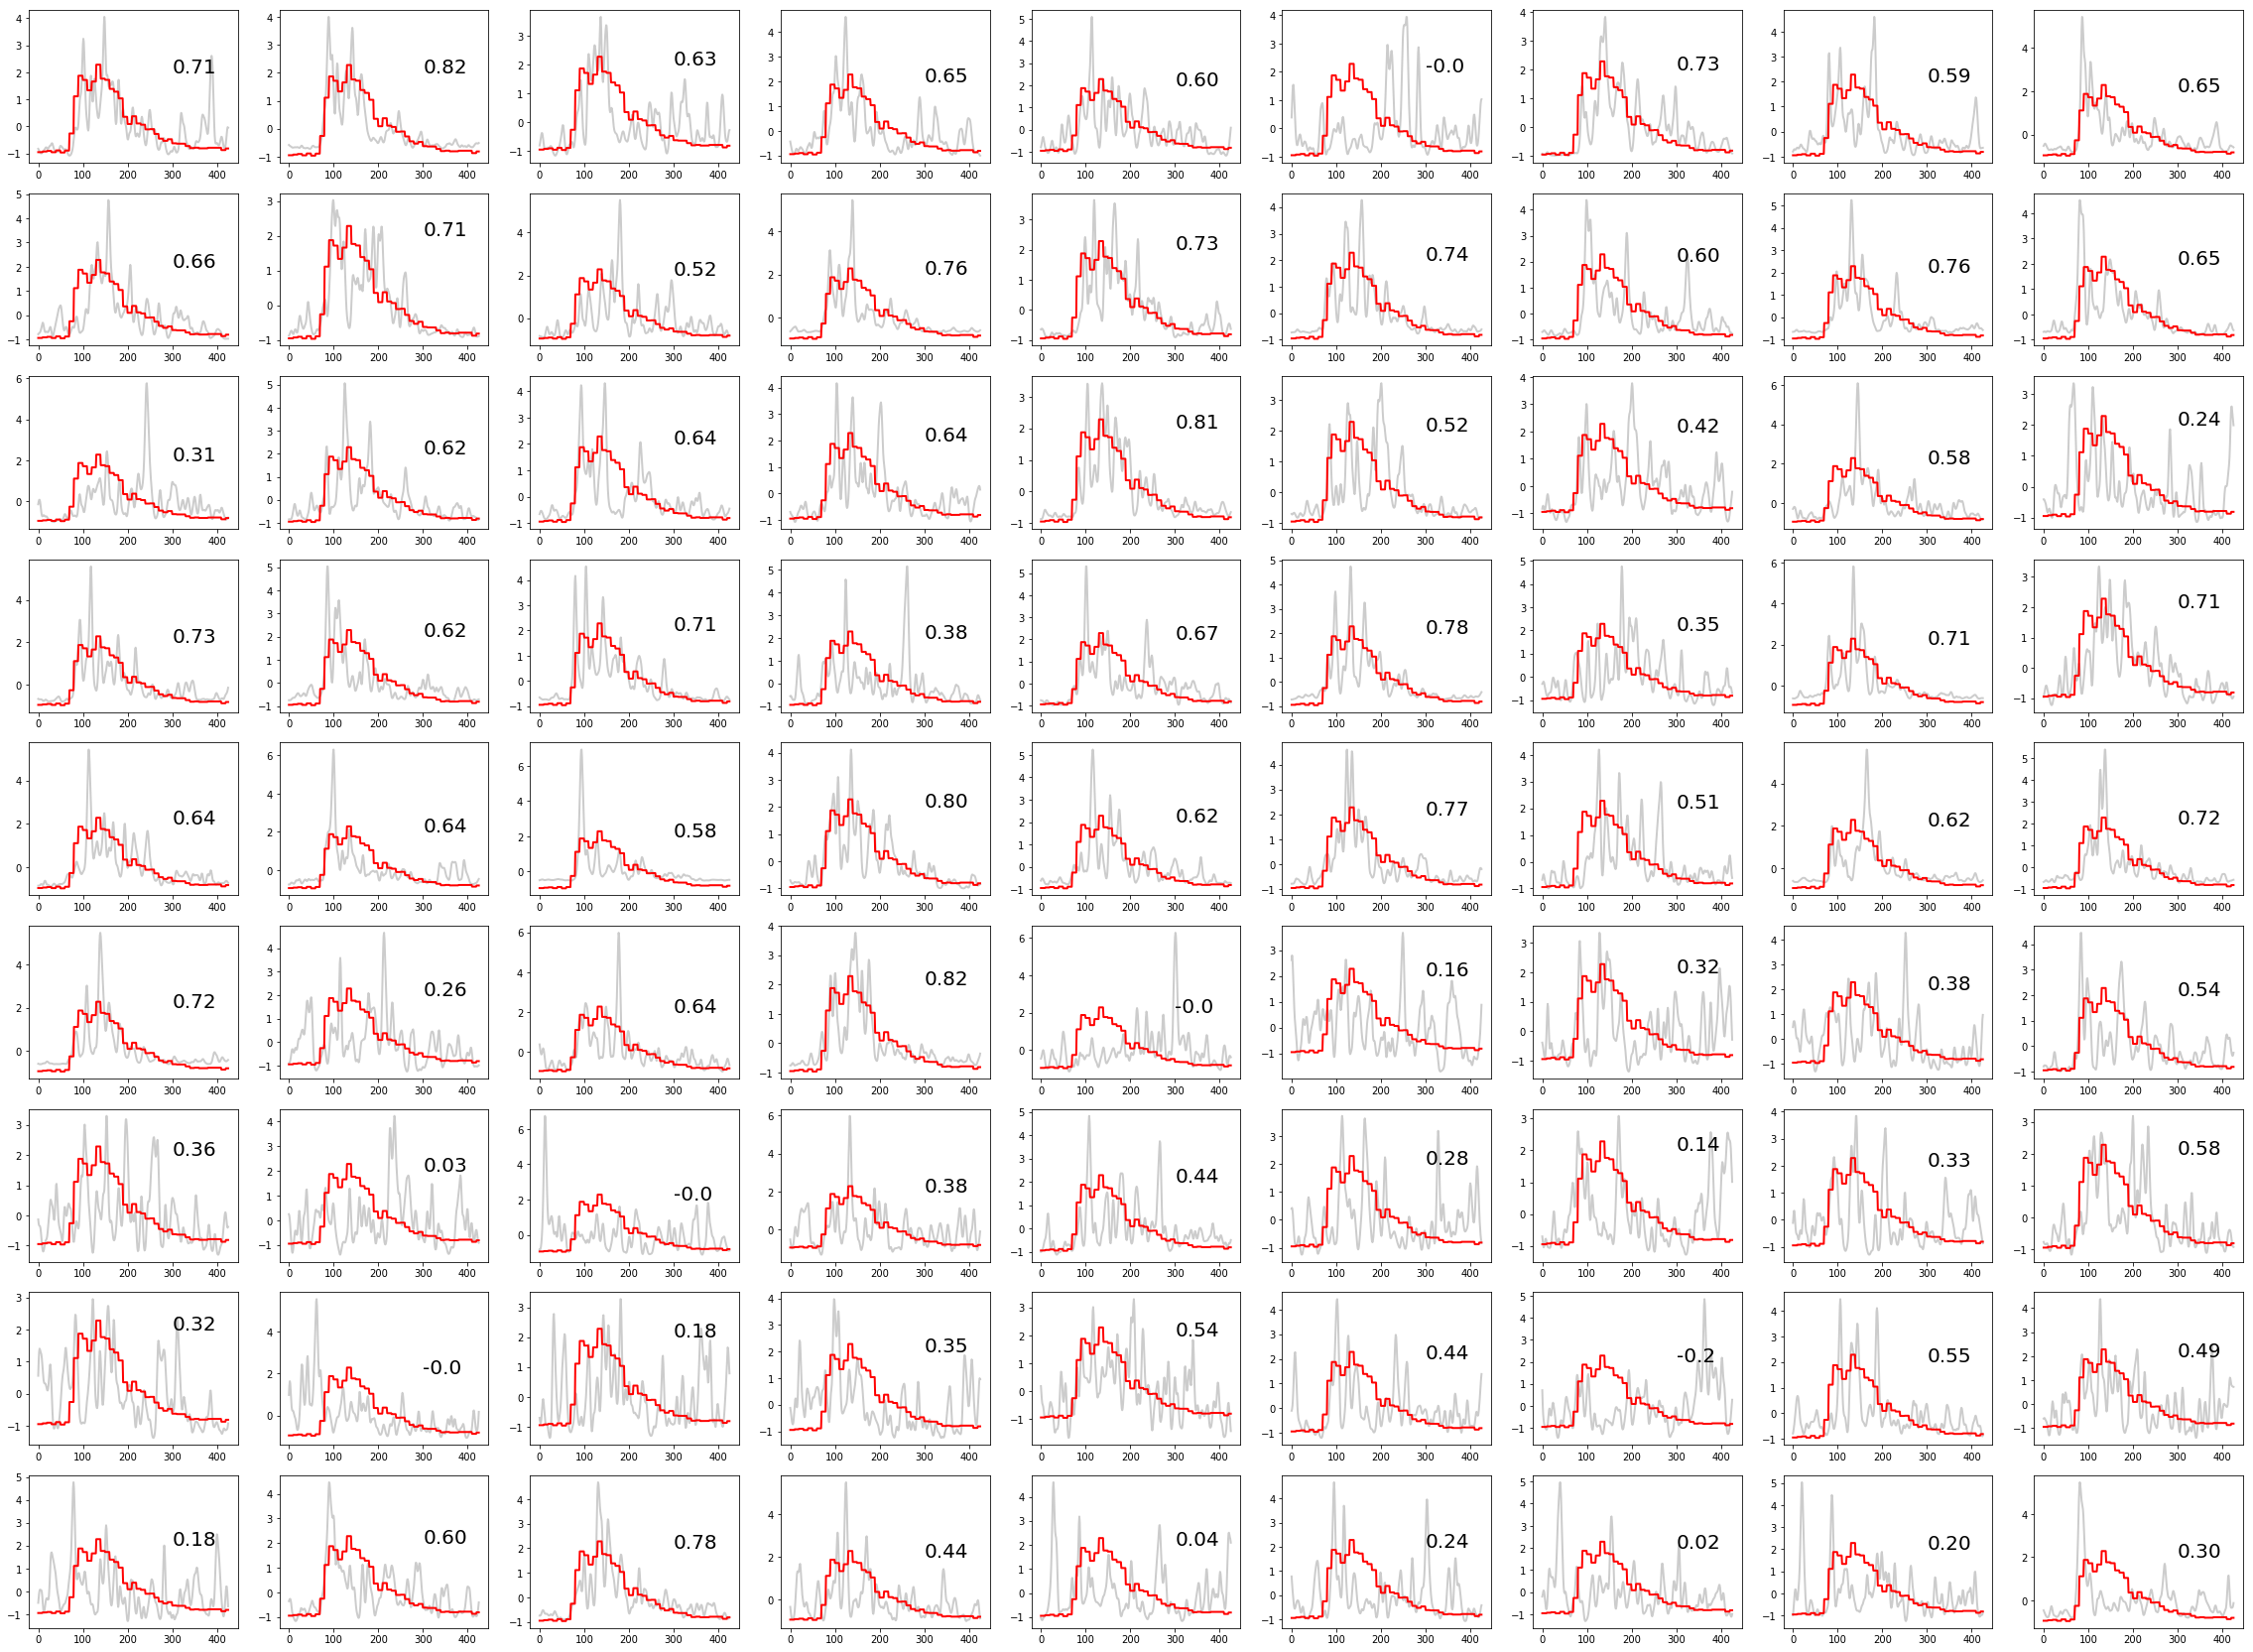

In [16]:
# Plot single trials predictions
features_list_plot = features_list[0:1]
for iif in range(0, len(features_list_plot)):
    trials_plot = np.unique(X['trials'][X[features_list_plot[iif]]==1])
    scores_trials = score_single_trials[elect,trials_plot-1] # to bring back to correct indices for scores
    y_pred = X_delay[X['trials']==trials_plot[0]]
    predictions = model.predict(y_pred)
    print(features_list[iif])
    subplot_dim = int(np.round(np.sqrt(len(trials_plot))))
    fig, axs = plt.subplots(nrows=subplot_dim,  ncols=subplot_dim, figsize=(40,30))
    for ax, it in zip(axs.flatten(), range(0,len(trials_plot))):
        y_true = scale(y[X['trials']==trials_plot[it], elect])
        y_pred = scale(predictions[:,elect])
        ax.plot(y_true, color='k', alpha=.2, lw=2)
        ax.plot(y_pred, color='r', lw=2)
        score_tmp = str(scores_trials[it])
        ax.text(300,2, score_tmp[0:4], fontsize=20)

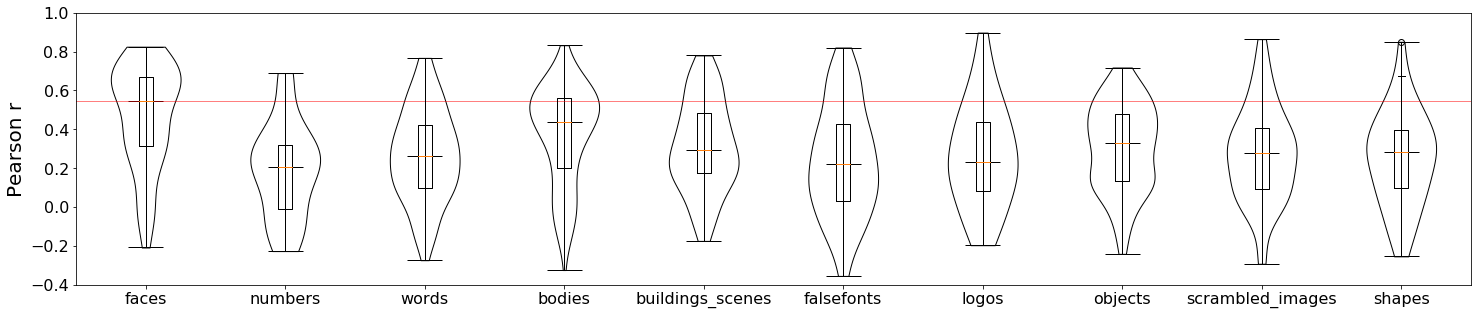

In [59]:
# Plot single electrode, single trial predicitons per feature
fig, ax = plt.subplots(nrows=1,  ncols=1, figsize=(25,5))
score_trials = []
for it in range(0,len(features_list)):
    trials_tmp = np.unique(X['trials'][X[features_list[it]]==1])
    scores_tmp = np.array(score_single_trials[elect,trials_tmp-1])
    
    #scores_tmp = scores_tmp[scores_tmp>=0]
    #score_trials.append(scores_tmp.tolist())
    score_trials.append(scores_tmp)

    
violin_parts = ax.violinplot(score_trials, showmedians=True)

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)
    
for vp in violin_parts['bodies']:
    vp.set_facecolor('w')
    vp.set_edgecolor('k')
    vp.set_linewidth(1)
    vp.set_alpha(1)
    
ax.boxplot(score_trials, widths=(0.1))
ax.set_xticklabels(features_list)
ax.set_ylim([-0.4,1])
ax.set_ylabel('Pearson r', size=20)
ax.tick_params(labelsize=16);

trials_faces = np.unique(X['trials'][X['faces']==1])
median_tmp = np.median(score_single_trials[elect,trials_faces-1])
plt.hlines(median_tmp, 0, 1000, linestyles='solid', colors='r', linewidths=0.5)

In [19]:
# Calculate median score for each electrode per condition
scores_features_elec = np.zeros((y.shape[1], len(features_list)))
for ie in range(0, y.shape[1]):
    for iif in range(0,len(features_list)):
        trials_tmp = np.unique(X['trials'][X[features_list[iif]]==1])
        scores_tmp = np.median(np.array(score_single_trials[ie,trials_tmp-1]))
        #print(scores_tmp)
        scores_features_elec[ie, iif] = scores_tmp
        #print(scores_features_elec[ie, iif])


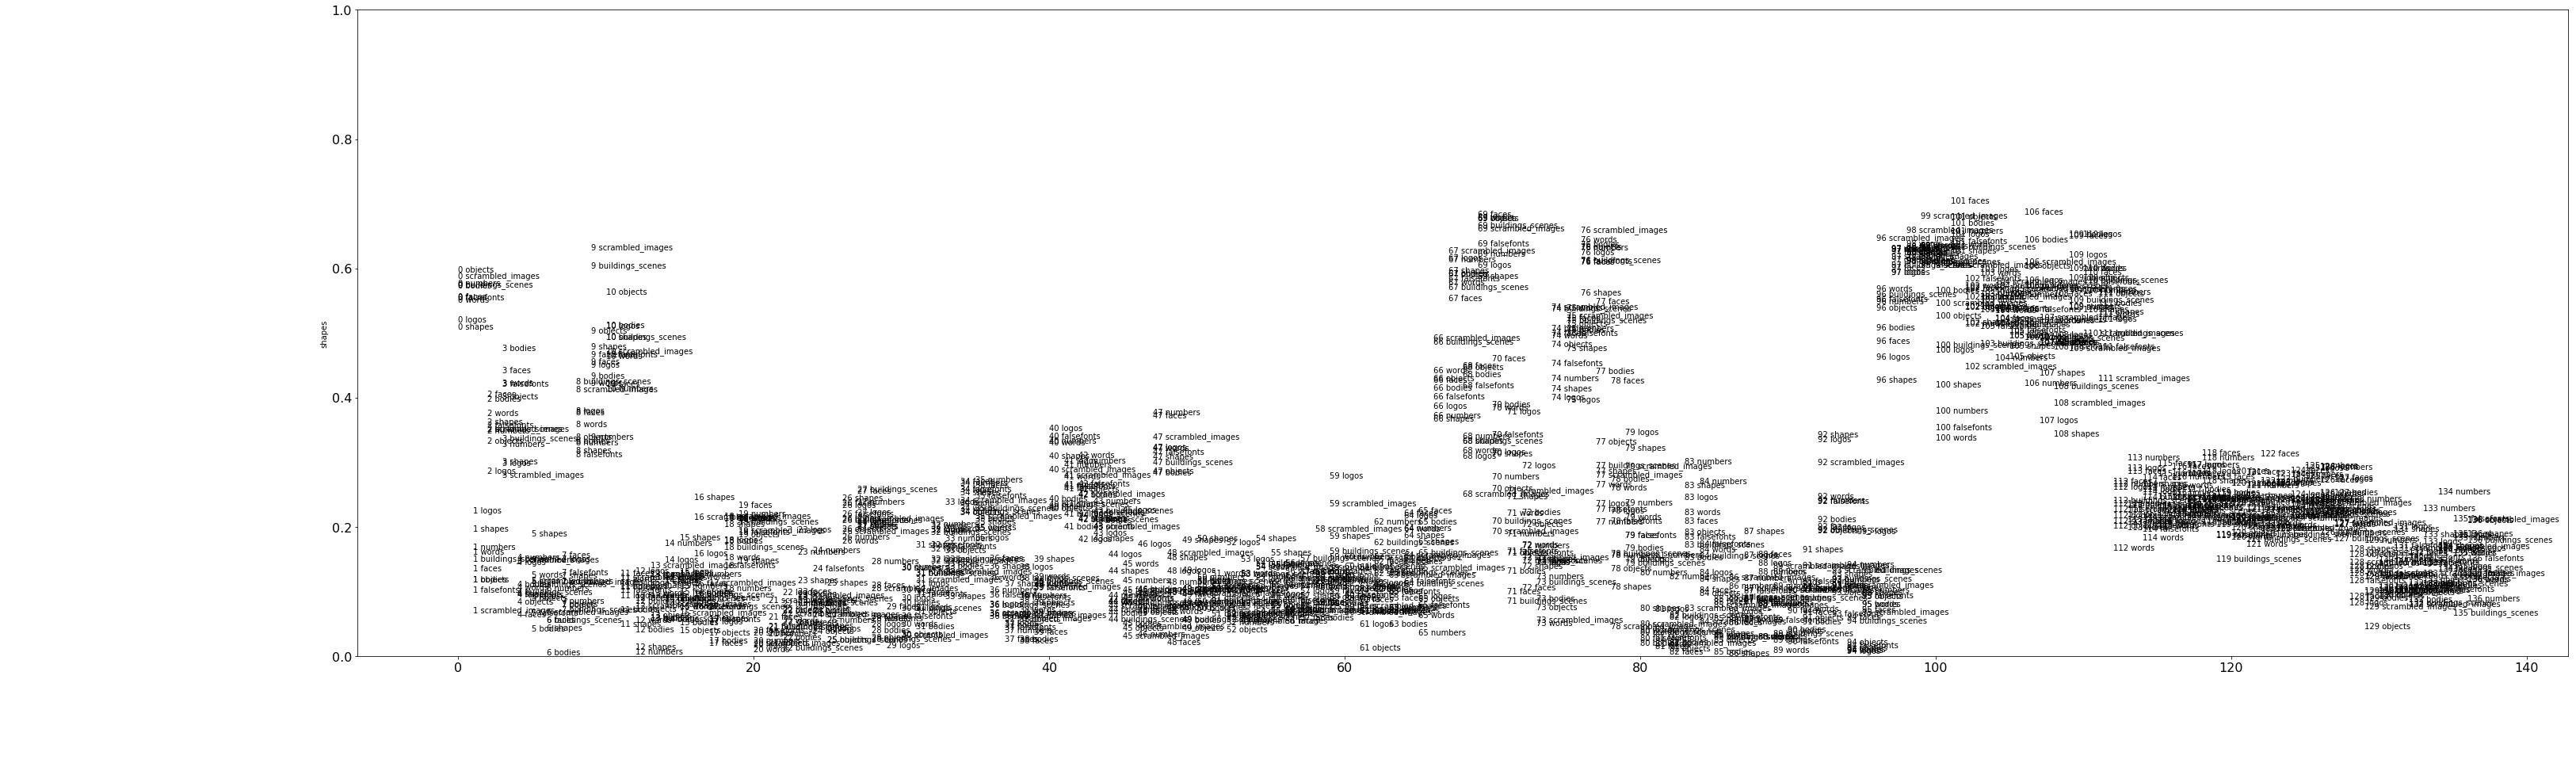

In [28]:
# Plot all electrodes single trial predicitons
electrodes = np.arange(0,y.shape[1])
fig, ax = plt.subplots(nrows=1,  ncols=1, figsize=(50,15))

for it in range(0,len(features_list)):
    scores_tmp = scores_features_elec[electrodes,it]
    ax.scatter(electrodes,scores_tmp, s=0.01)
    for i, txt in enumerate(electrodes):
        ax.annotate(str(txt) + ' ' + features_list[it], (electrodes[i], scores_tmp[i]), size=10)
    plt.tick_params(labelsize=16);
    ax.set_ylabel(features_list[it], size=10)
    ax.set_ylim([0,1])

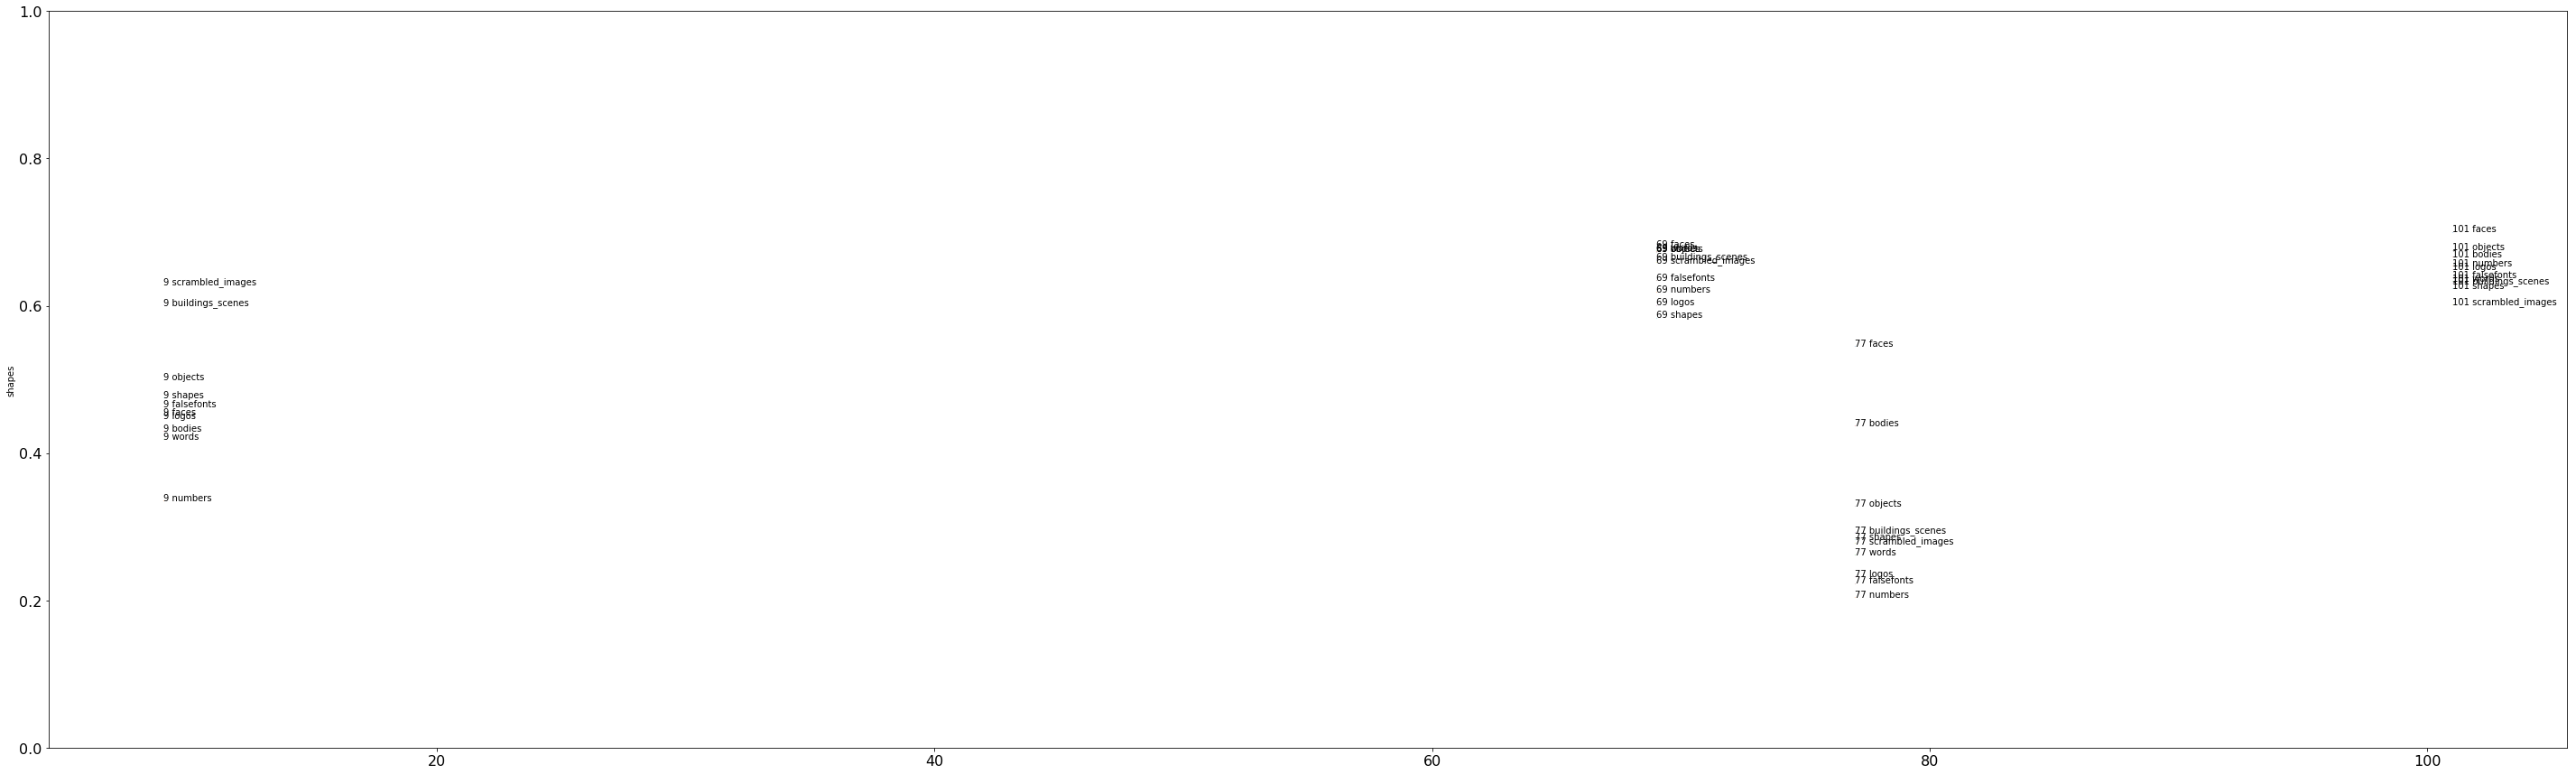

In [33]:
# Explore some electrodes
electrodes = [9, 69, 77, 101]
fig, ax = plt.subplots(nrows=1,  ncols=1, figsize=(50,15))

for it in range(0,len(features_list)):
    scores_tmp = scores_features_elec[electrodes,it]
    ax.scatter(electrodes,scores_tmp, s=0.01)
    for i, txt in enumerate(electrodes):
        ax.annotate(str(txt) + ' ' + features_list[it], (electrodes[i], scores_tmp[i]), size=10)
    plt.tick_params(labelsize=16);
    ax.set_ylabel(features_list[it], size=10)
    ax.set_ylim([0,1])

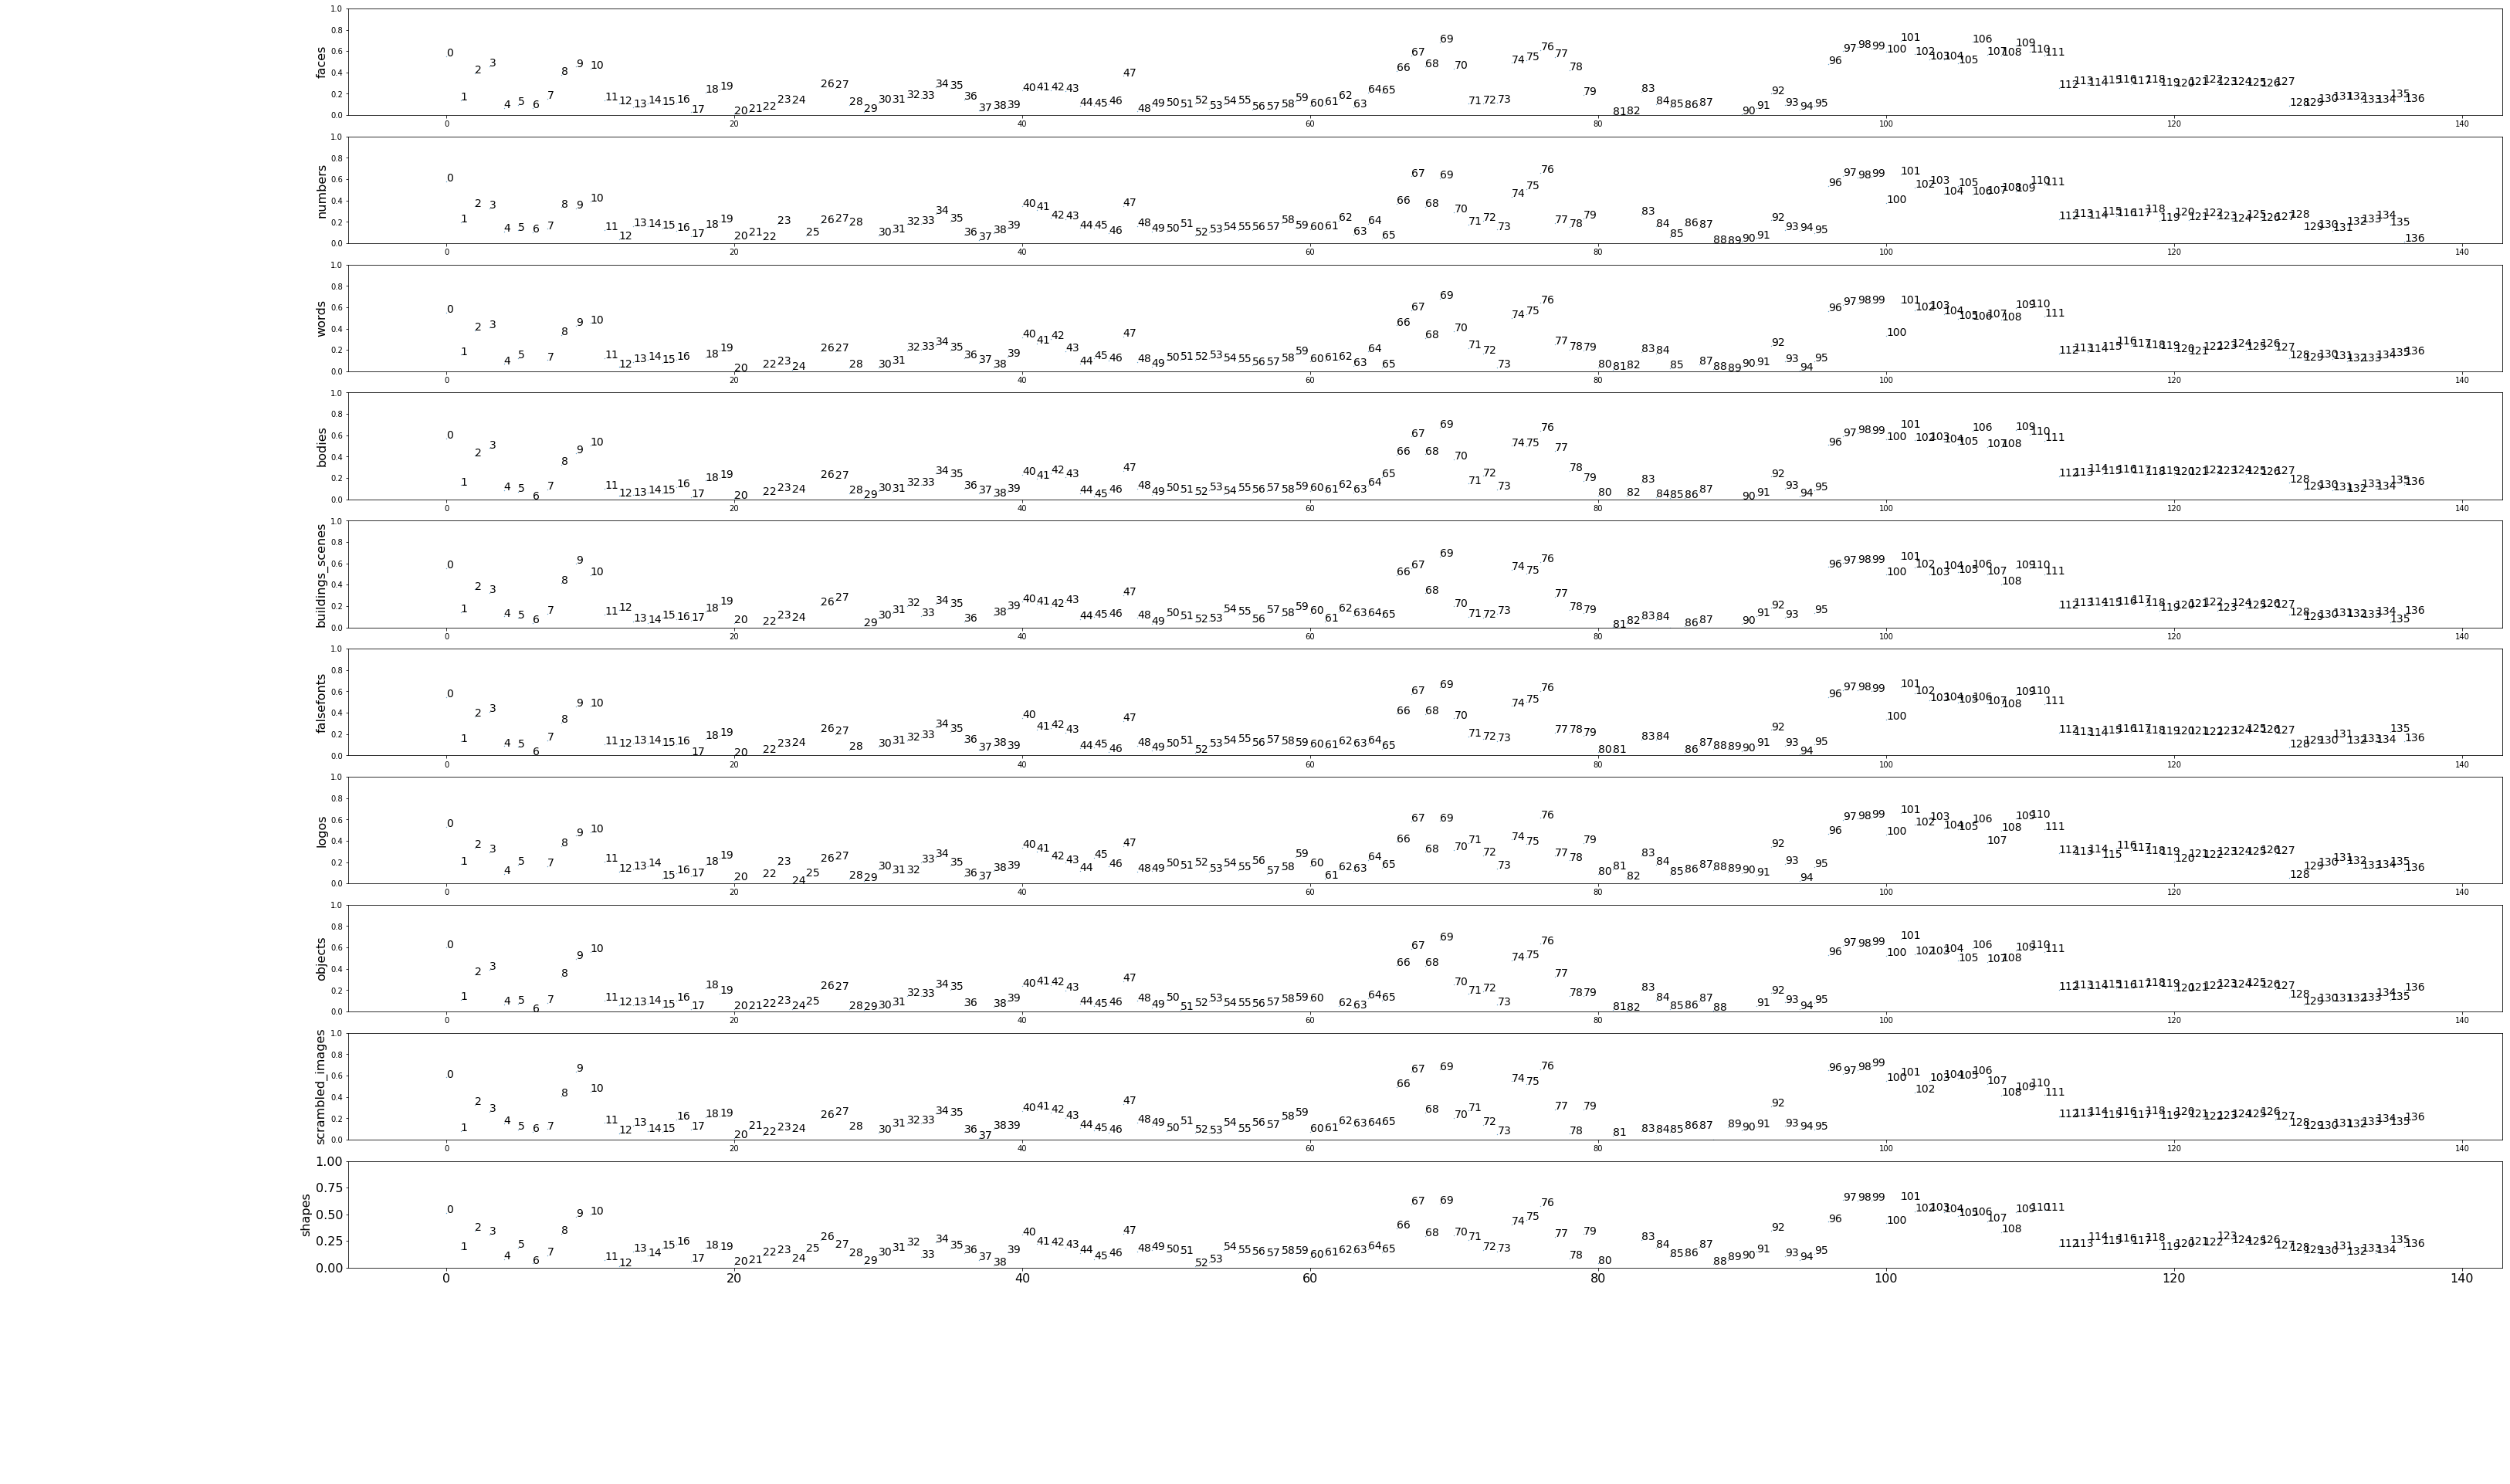

In [107]:
# Plot all electrodes single trial predicitons, per feature
electrodes = np.arange(0,y.shape[1])
fig, axs = plt.subplots(nrows=len(features_list),  ncols=1, figsize=(50,30))

for ax, it in zip(axs.flatten(),range(0,len(features_list))):
    scores_tmp = scores_features_elec[:,it]
    ax.scatter(electrodes,scores_tmp, s=0.1)
    for i, txt in enumerate(electrodes):
        ax.annotate(txt, (electrodes[i], scores_tmp[i]), size=14)
    plt.tick_params(labelsize=16);
    ax.set_ylabel(features_list[it], size=16)
    ax.set_ylim([0,1])

In [ ]:
# Plot all chanells single trial predicitons
subplot_dim = int(np.round(np.sqrt(y.shape[1])))
fig, axs = plt.subplots(nrows=subplot_dim,  ncols=subplot_dim, figsize=(60,60))
for ie, ax in zip(range(0, y.shape[1]), axs.flatten()):
    score_trials = []
    for it in range(0,len(features_list)):
        trials_tmp = np.unique(X['trials'][X[features_list[it]]==1])
        scores_tmp = np.array(score_single_trials[ie,trials_tmp-1])
        #scores_tmp = scores_tmp[scores_tmp>=0]
        #score_trials.append(scores_tmp.tolist())
        score_trials.append(scores_tmp)

    violin_parts = ax.violinplot(score_trials, showmedians=True)

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

    for vp in violin_parts['bodies']:
        vp.set_facecolor('w')
        vp.set_edgecolor('k')
        vp.set_linewidth(1)
        vp.set_alpha(1)

    ax.boxplot(score_trials, widths=(0.1))
    ax.set_xticklabels(features_list)
    ax.set_ylim([-0.4,1])
    ax.tick_params(labelsize=8);

    trials_faces = np.unique(X['trials'][X['faces']==1])
    median_tmp = np.median(score_single_trials[ie,trials_faces-1])
    plt.hlines(median_tmp, 0, 1000, linestyles='solid', colors='r', linewidths=0.5)

In [ ]:
sbj_name: 'S13_57_TVD'
cortex: [1×1 struct]
V: [256×256×256 uint8]
labels_EDF: []
demographics: [1×8 table]
elinfo: [128×21 table]
